In [1]:
from matplotlib import pyplot
import pandas as pd
import warnings

from summer.utils import ref_times_to_dti

from autumn.tools.plots.utils import REF_DATE
from autumn.tools.project import get_project
from autumn.tools.utils.pretty import pretty_print

In [2]:
pyplot.style.use("ggplot")
warnings.filterwarnings("ignore")

region = "malaysia"
project = get_project("sm_sir", region)

In [3]:
# pretty_print(project.param_set.baseline)

In [7]:
baseline_params = project.param_set.baseline
custom_params = project.param_set.baseline.update(
    {
        "time": {"end": 1000.},
        "voc_emergence": {
            "omicron": {
                "contact_rate_multiplier": 3.,
                "entry_rate": 50.,
            }
        },
    }
)

In [8]:
model = project.run_baseline_model(custom_params)
derived_df = model.get_derived_outputs_df()

model_start_time = ref_times_to_dti(REF_DATE, [custom_params["time"]["start"]])[0]
model_end_time = ref_times_to_dti(REF_DATE, [custom_params["time"]["end"]])[0]

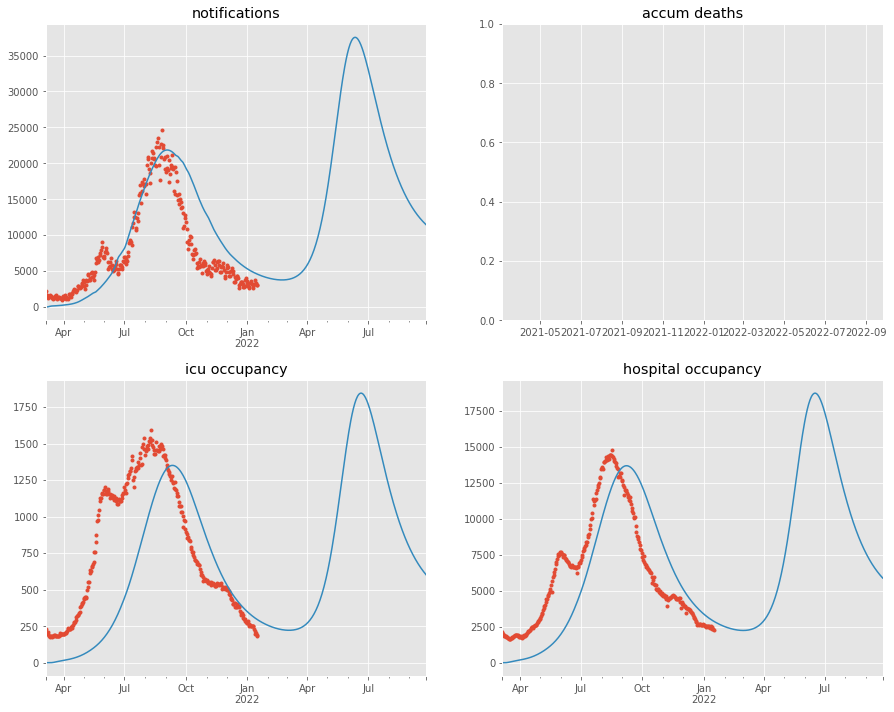

In [9]:
targets_dict = {
    t.data.name: pd.Series(t.data.data, index=ref_times_to_dti(model.ref_date, t.data.index)) for 
    t in project.calibration.targets
}
death_string = "accum_deaths" if region == "bangladesh" else "infection_deaths"
outputs_to_plot = ["notifications", "accum_deaths", "icu_occupancy", "hospital_occupancy"]

fig = pyplot.figure(figsize=(15, 12))
for i_out, output in enumerate(outputs_to_plot):
    axis = fig.add_subplot(2, 2, i_out + 1)
    if output in targets_dict:
        targets_dict[output].plot(ax=axis, style='.')
    if output in derived_df:
        derived_df[output].plot(ax=axis)
    axis.set_title(output.replace("_", " "))
    axis.set_xlim([model_start_time, model_end_time])